In [ ]:
!pip install yfinance --upgrade
!pip install pandas matplotlib

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from tqdm.notebook  import tqdm
import yfinance as yf
import datetime as dt
import math
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
import numpy as np
import time

# Загрузка данных
df = pd.read_csv('insidersData_cleaned.csv')
df['Trade Date'] = pd.to_datetime(df['Trade Date'])

# Функция для преобразования строк в числа
def parse_value(value):
    try:
        # Удаляем $, запятые и пробелы
        value = str(value).replace('$', '').replace(',', '').strip()
        return float(value) if value else 0.0
    except:
        return 0.0

# Преобразуем колонки Price и Qty
df['Price'] = df['Price'].apply(parse_value)
df['Qty'] = df['Qty'].apply(parse_value)

# Функция для расчета аномальной доходности
def calculate_abnormal_returns(ticker, trade_date, window_before=30, window_after=10):
    try:
        # Определяем даты
        start_date = trade_date - timedelta(days=window_before)
        end_date = trade_date + timedelta(days=window_after)

        # Загружаем данные
        stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        market_data = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

        if stock_data.empty or market_data.empty:
            return np.nan, np.nan, np.nan

        # Объединяем данные
        merged = pd.DataFrame(index=stock_data.index.union(market_data.index))
        merged['Stock_Return'] = stock_data['Close'].pct_change()
        merged['Market_Return'] = market_data['Close'].pct_change()
        merged = merged.dropna()

        if len(merged) < 5:
            return np.nan, np.nan, np.nan

        # Разделяем данные на период до и после сделки
        pre_event = merged.loc[merged.index < trade_date].copy()  # Явное создание копии
        post_event = merged.loc[merged.index >= trade_date].copy()  # Явное создание копии

        if len(pre_event) < 10:
            return np.nan, np.nan, np.nan

        # Рассчитываем CAPM
        X = sm.add_constant(pre_event['Market_Return'])
        y = pre_event['Stock_Return']
        model = sm.OLS(y, X).fit()
        alpha, beta = model.params['const'], model.params['Market_Return']

        # Расчет аномальной доходности с использованием .loc
        post_event.loc[:, 'Expected_Return'] = alpha + beta * post_event['Market_Return']
        post_event.loc[:, 'Abnormal_Return'] = post_event['Stock_Return'] - post_event['Expected_Return']

        mean_ar = post_event['Abnormal_Return'].mean()
        cumulative_ar = post_event['Abnormal_Return'].sum()
        p_value = model.pvalues['Market_Return']

        return mean_ar, cumulative_ar, p_value

    except Exception as e:
        print(f"Ошибка для {ticker} на {trade_date}: {str(e)}")
        return np.nan, np.nan, np.nan

# Добавляем новые колонки
df['Mean_AR'] = np.nan
df['Cumulative_AR'] = np.nan
df['Beta_p_value'] = np.nan

# Обрабатываем каждую транзакцию
for i, row in df.iterrows():
    ticker = row['Ticker']
    trade_date = row['Trade Date']

    # Пропускаем транзакции с нулевой ценой или малым объемом
    if row['Price'] <= 0 or abs(row['Qty']) < 100:
        continue

    mean_ar, cumulative_ar, p_value = calculate_abnormal_returns(ticker, trade_date)

    # Используем .loc для безопасного присвоения значений
    df.loc[i, 'Mean_AR'] = mean_ar
    df.loc[i, 'Cumulative_AR'] = cumulative_ar
    df.loc[i, 'Beta_p_value'] = p_value

    # Логируем прогресс
    if i % 10 == 0:
        print(f"Обработано {i+1}/{len(df)} транзакций...")
    time.sleep(1)  # Задержка для избежания блокировки Yahoo Finance

# Сохраняем обновленный датасет
df.to_csv('insidersData_with_AR.csv', index=False)
print("Анализ завершен. Результаты сохранены в 'insidersData_with_AR.csv'")

YF.download() has changed argument auto_adjust default to True
Обработано 1/9591 транзакций...
Обработано 11/9591 транзакций...
Обработано 21/9591 транзакций...
Обработано 31/9591 транзакций...
Обработано 41/9591 транзакций...
Обработано 71/9591 транзакций...
Обработано 81/9591 транзакций...
Обработано 91/9591 транзакций...
Обработано 101/9591 транзакций...
Обработано 121/9591 транзакций...
Обработано 131/9591 транзакций...
Обработано 141/9591 транзакций...
Обработано 151/9591 транзакций...
Обработано 161/9591 транзакций...
Обработано 171/9591 транзакций...
Обработано 181/9591 транзакций...
Обработано 191/9591 транзакций...
Обработано 201/9591 транзакций...
Обработано 211/9591 транзакций...
Обработано 221/9591 транзакций...
Обработано 231/9591 транзакций...
Обработано 241/9591 транзакций...
Обработано 251/9591 транзакций...
Обработано 261/9591 транзакций...
Обработано 281/9591 транзакций...
Обработано 291/9591 транзакций...
Обработано 301/9591 транзакций...
Обработано 311/9591 транзакц

In [ ]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('insidersData_with_AR.csv')

# Удаление строк, где хотя бы одна из указанных колонок имеет пустое или нулевое значение
df_cleaned = df.dropna(subset=['Mean_AR', 'Cumulative_AR', 'Beta_p_value'], how='any')

# Дополнительно: удаление строк, где значения равны 0 (если нужно)
df_cleaned = df_cleaned[
    (df_cleaned['Mean_AR'] != 0) &
    (df_cleaned['Cumulative_AR'] != 0) &
    (df_cleaned['Beta_p_value'] != 0)
]


In [ ]:
df = df_cleaned

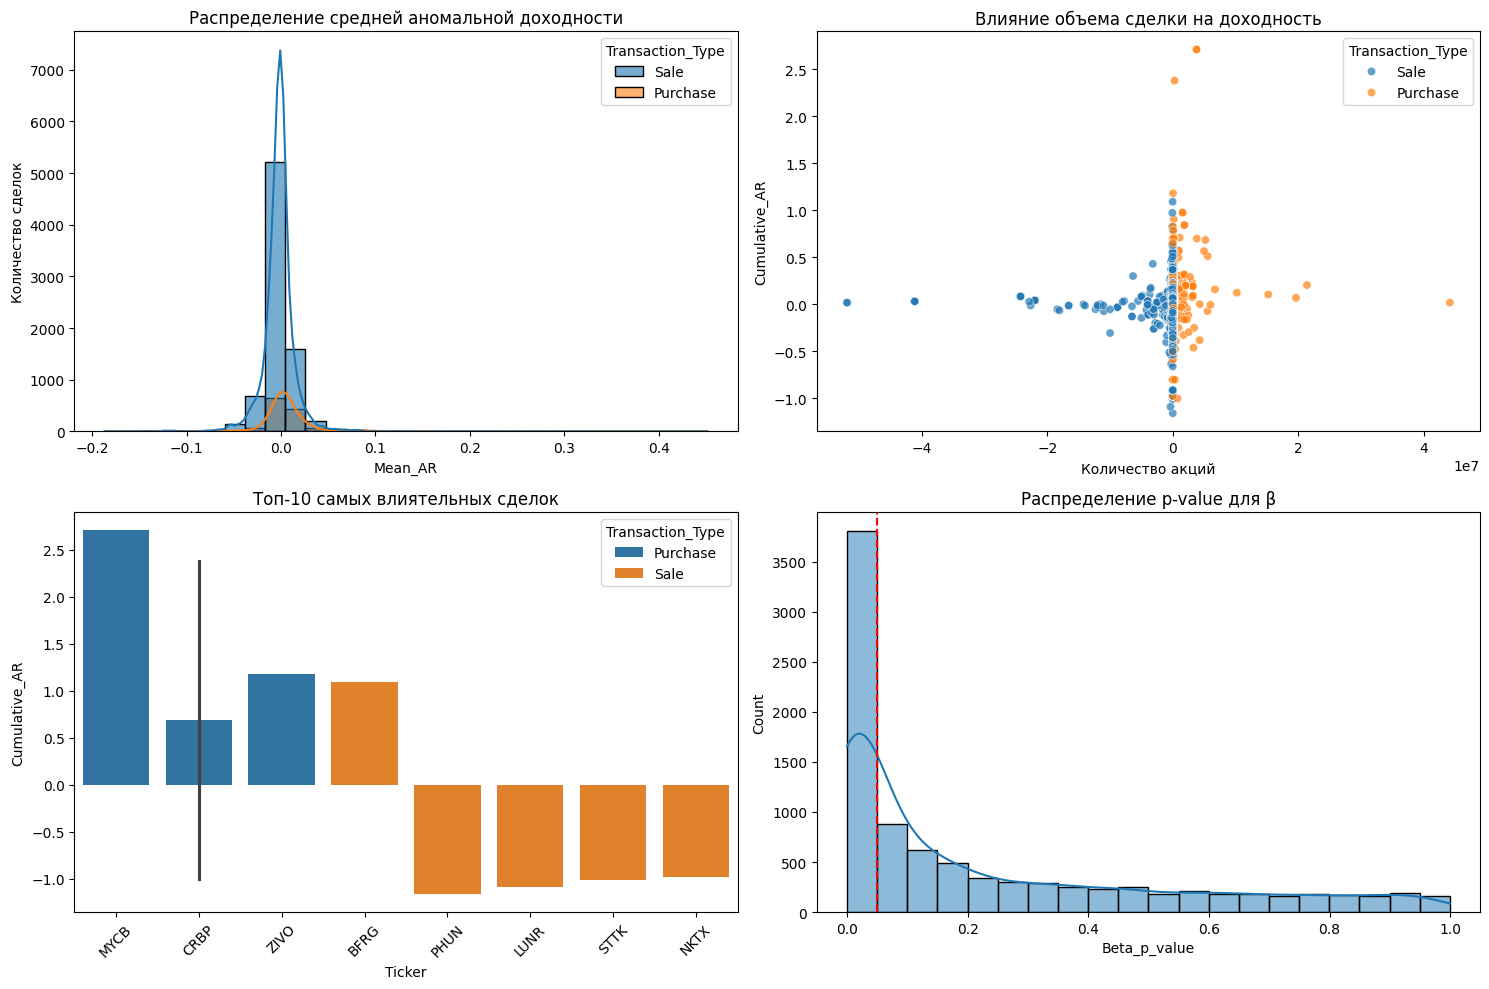

ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА

1. Статистика по типам сделок:
                 Mean_AR               Cumulative_AR           Beta_p_value
                    mean     std count          mean       sum     <lambda>
Transaction_Type                                                           
Purchase          0.0061  0.0319  1288        0.0423   54.4275       0.2252
Sale             -0.0023  0.0163  7941       -0.0160 -126.8415       0.4428

2. T-тест (покупки vs продажи): p-value = 0.0000
3. Доля влиятельных сделок (|Mean_AR| > 1% и p-value β < 0.05): 12.2%

4. Интерпретация:
- Инсайдерские покупки имеют значимо более положительное влияние, чем продажи
- Менее половины сделок оказывают значимое влияние на рынок

Анализ завершен. Результаты сохранены в 'insidersData_analyzed.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



# 2. Разделение сделок на покупки и продажи
df_cleaned['Transaction_Type'] = df_cleaned['Type'].apply(
    lambda x: 'Purchase' if 'Purchase' in x else ('Sale' if 'Sale' in x else 'Other')
)

# 3. Статистический анализ
def analyze_insider_impact(df):
    # Основные статистики
    stats_summary = df.groupby('Transaction_Type').agg({
        'Mean_AR': ['mean', 'std', 'count'],
        'Cumulative_AR': ['mean', 'sum'],
        'Beta_p_value': lambda x: (x < 0.05).mean()
    }).round(4)

    # T-тест для сравнения покупок и продаж
    purchase_ar = df[df['Transaction_Type'] == 'Purchase']['Mean_AR']
    sale_ar = df[df['Transaction_Type'] == 'Sale']['Mean_AR']
    t_stat, p_value = stats.ttest_ind(purchase_ar, sale_ar)

    # Расчет доли влиятельных сделок
    influential = df[(abs(df['Mean_AR']) > 0.01) & (df['Beta_p_value'] < 0.05)]
    influential_pct = len(influential) / len(df) * 100

    return stats_summary, t_stat, p_value, influential_pct

stats_summary, t_stat, p_value, influential_pct = analyze_insider_impact(df_cleaned)

# 4. Визуализация
def plot_analysis_results(df):
    plt.figure(figsize=(15, 10))

    # График 1: Распределение Mean_AR
    plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='Mean_AR', hue='Transaction_Type',
                bins=30, kde=True, alpha=0.6)
    plt.title('Распределение средней аномальной доходности')
    plt.xlabel('Mean_AR')
    plt.ylabel('Количество сделок')

    # График 2: Cumulative_AR vs Объем сделки
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=df, x='Qty', y='Cumulative_AR',
                   hue='Transaction_Type', alpha=0.7)
    plt.title('Влияние объема сделки на доходность')
    plt.xlabel('Количество акций')
    plt.ylabel('Cumulative_AR')

    # График 3: Топ-10 самых влиятельных сделок
    plt.subplot(2, 2, 3)
    top_combined = pd.concat([
        df.nlargest(5, 'Cumulative_AR'),
        df.nsmallest(5, 'Cumulative_AR')
    ])
    sns.barplot(data=top_combined, x='Ticker', y='Cumulative_AR',
                hue='Transaction_Type')
    plt.title('Топ-10 самых влиятельных сделок')
    plt.xticks(rotation=45)

    # График 4: Надежность модели (p-value beta)
    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='Beta_p_value', bins=20, kde=True)
    plt.axvline(0.05, color='red', linestyle='--')
    plt.title('Распределение p-value для β')
    plt.xlabel('Beta_p_value')

    plt.tight_layout()
    plt.show()

plot_analysis_results(df_cleaned)

# 5. Вывод результатов анализа
print("="*50)
print("ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА")
print("="*50)
print("\n1. Статистика по типам сделок:")
print(stats_summary)

print(f"\n2. T-тест (покупки vs продажи): p-value = {p_value:.4f}")
print(f"3. Доля влиятельных сделок (|Mean_AR| > 1% и p-value β < 0.05): {influential_pct:.1f}%")

print("\n4. Интерпретация:")
if p_value < 0.05:
    if stats_summary[('Mean_AR', 'mean')]['Purchase'] > stats_summary[('Mean_AR', 'mean')]['Sale']:
        print("- Инсайдерские покупки имеют значимо более положительное влияние, чем продажи")
    else:
        print("- Инсайдерские продажи имеют значимо более отрицательное влияние, чем покупки")
else:
    print("- Нет значимой разницы между влиянием покупок и продаж")

if influential_pct > 50:
    print("- Большинство сделок оказывают значимое влияние на рынок")
else:
    print("- Менее половины сделок оказывают значимое влияние на рынок")

print("\nАнализ завершен. Результаты сохранены в 'insidersData_analyzed.csv'")

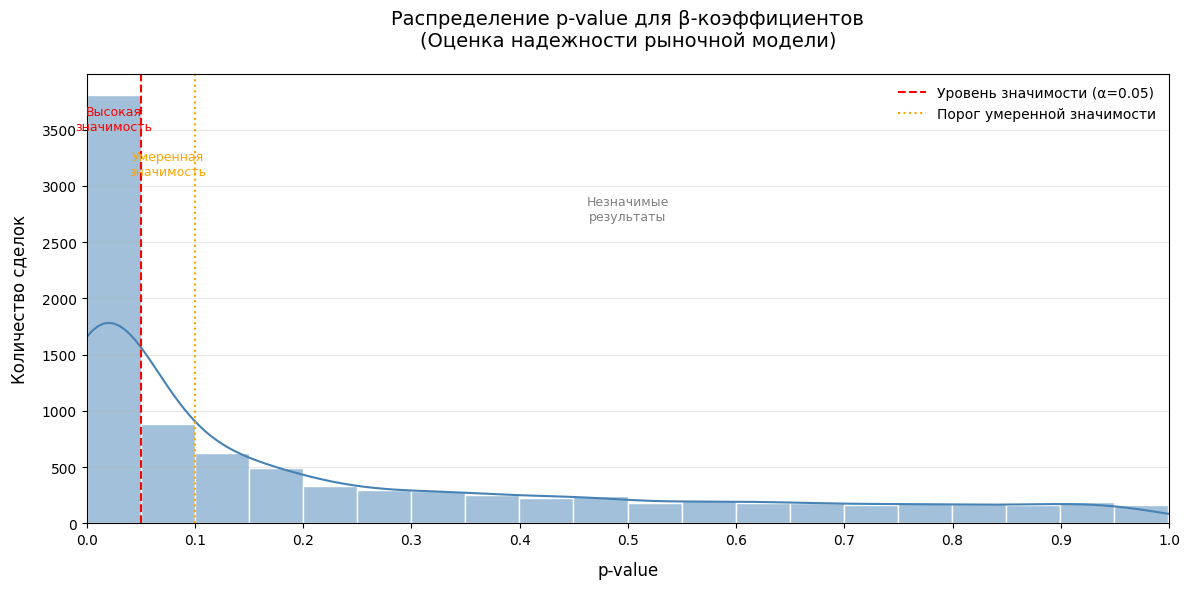

ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА

1. Статистика по типам сделок:
                 Mean_AR               Cumulative_AR           Beta_p_value
                    mean     std count          mean       sum     <lambda>
Transaction_Type                                                           
Purchase          0.0061  0.0319  1288        0.0423   54.4275       0.2252
Sale             -0.0023  0.0163  7941       -0.0160 -126.8415       0.4428

2. T-тест (покупки vs продажи): p-value = 0.0000
3. Доля влиятельных сделок (|Mean_AR| > 1% и p-value β < 0.05): 12.2%

4. Анализ значимости:
- Доля высокозначимых сделок (p < 0.05): 41.2%
- Доля умеренно значимых сделок (0.05 ≤ p < 0.1): 9.6%

5. Интерпретация:
- Инсайдерские покупки имеют значимо более положительное влияние, чем продажи
- Менее половины сделок оказывают значимое влияние на рынок

Анализ завершен.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 2. Разделение сделок на покупки и продажи
df_cleaned['Transaction_Type'] = df_cleaned['Type'].apply(
    lambda x: 'Purchase' if 'Purchase' in x else ('Sale' if 'Sale' in x else 'Other')
)

# 3. Статистический анализ
def analyze_insider_impact(df):
    # Основные статистики
    stats_summary = df.groupby('Transaction_Type').agg({
        'Mean_AR': ['mean', 'std', 'count'],
        'Cumulative_AR': ['mean', 'sum'],
        'Beta_p_value': lambda x: (x < 0.05).mean()
    }).round(4)

    # T-тест для сравнения покупок и продаж
    purchase_ar = df[df['Transaction_Type'] == 'Purchase']['Mean_AR']
    sale_ar = df[df['Transaction_Type'] == 'Sale']['Mean_AR']
    t_stat, p_value = stats.ttest_ind(purchase_ar, sale_ar)

    # Расчет доли влиятельных сделок
    influential = df[(abs(df['Mean_AR']) > 0.01) & (df['Beta_p_value'] < 0.05)]
    influential_pct = len(influential) / len(df) * 100

    return stats_summary, t_stat, p_value, influential_pct

stats_summary, t_stat, p_value, influential_pct = analyze_insider_impact(df_cleaned)

# 4. Улучшенная визуализация только распределения p-value
plt.figure(figsize=(12, 6))

# Гистограмма с KDE
ax = sns.histplot(data=df_cleaned, x='Beta_p_value', bins=20,
                 kde=True, color='steelblue', edgecolor='white')

# Вертикальные линии для критических значений
plt.axvline(0.05, color='red', linestyle='--', linewidth=1.5,
            label='Уровень значимости (α=0.05)')
plt.axvline(0.1, color='orange', linestyle=':', linewidth=1.5,
           label='Порог умеренной значимости')

# Аннотации
plt.text(0.025, ax.get_ylim()[1]*0.9, 'Высокая\nзначимость',
         ha='center', va='center', color='red', fontsize=9)
plt.text(0.075, ax.get_ylim()[1]*0.8, 'Умеренная\nзначимость',
         ha='center', va='center', color='orange', fontsize=9)
plt.text(0.5, ax.get_ylim()[1]*0.7, 'Незначимые\nрезультаты',
         ha='center', va='center', color='gray', fontsize=9)

# Настройки оформления
plt.title('Распределение p-value для β-коэффициентов\n(Оценка надежности рыночной модели)', pad=20, fontsize=14)
plt.xlabel('p-value', labelpad=10, fontsize=12)
plt.ylabel('Количество сделок', labelpad=10, fontsize=12)
plt.legend(frameon=False, fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Улучшенная шкала оси X
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

# 5. Вывод результатов анализа
print("="*50)
print("ОСНОВНЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА")
print("="*50)
print("\n1. Статистика по типам сделок:")
print(stats_summary)

print(f"\n2. T-тест (покупки vs продажи): p-value = {p_value:.4f}")
print(f"3. Доля влиятельных сделок (|Mean_AR| > 1% и p-value β < 0.05): {influential_pct:.1f}%")

# Дополнительная аналитика по p-value
significant = (df_cleaned['Beta_p_value'] < 0.05).mean() * 100
moderate = ((df_cleaned['Beta_p_value'] >= 0.05) &
            (df_cleaned['Beta_p_value'] < 0.1)).mean() * 100

print(f"\n4. Анализ значимости:")
print(f"- Доля высокозначимых сделок (p < 0.05): {significant:.1f}%")
print(f"- Доля умеренно значимых сделок (0.05 ≤ p < 0.1): {moderate:.1f}%")

print("\n5. Интерпретация:")
if p_value < 0.05:
    if stats_summary[('Mean_AR', 'mean')]['Purchase'] > stats_summary[('Mean_AR', 'mean')]['Sale']:
        print("- Инсайдерские покупки имеют значимо более положительное влияние, чем продажи")
    else:
        print("- Инсайдерские продажи имеют значимо более отрицательное влияние, чем покупки")
else:
    print("- Нет значимой разницы между влиянием покупок и продаж")

if influential_pct > 50:
    print("- Большинство сделок оказывают значимое влияние на рынок")
else:
    print("- Менее половины сделок оказывают значимое влияние на рынок")

print("\nАнализ завершен.")

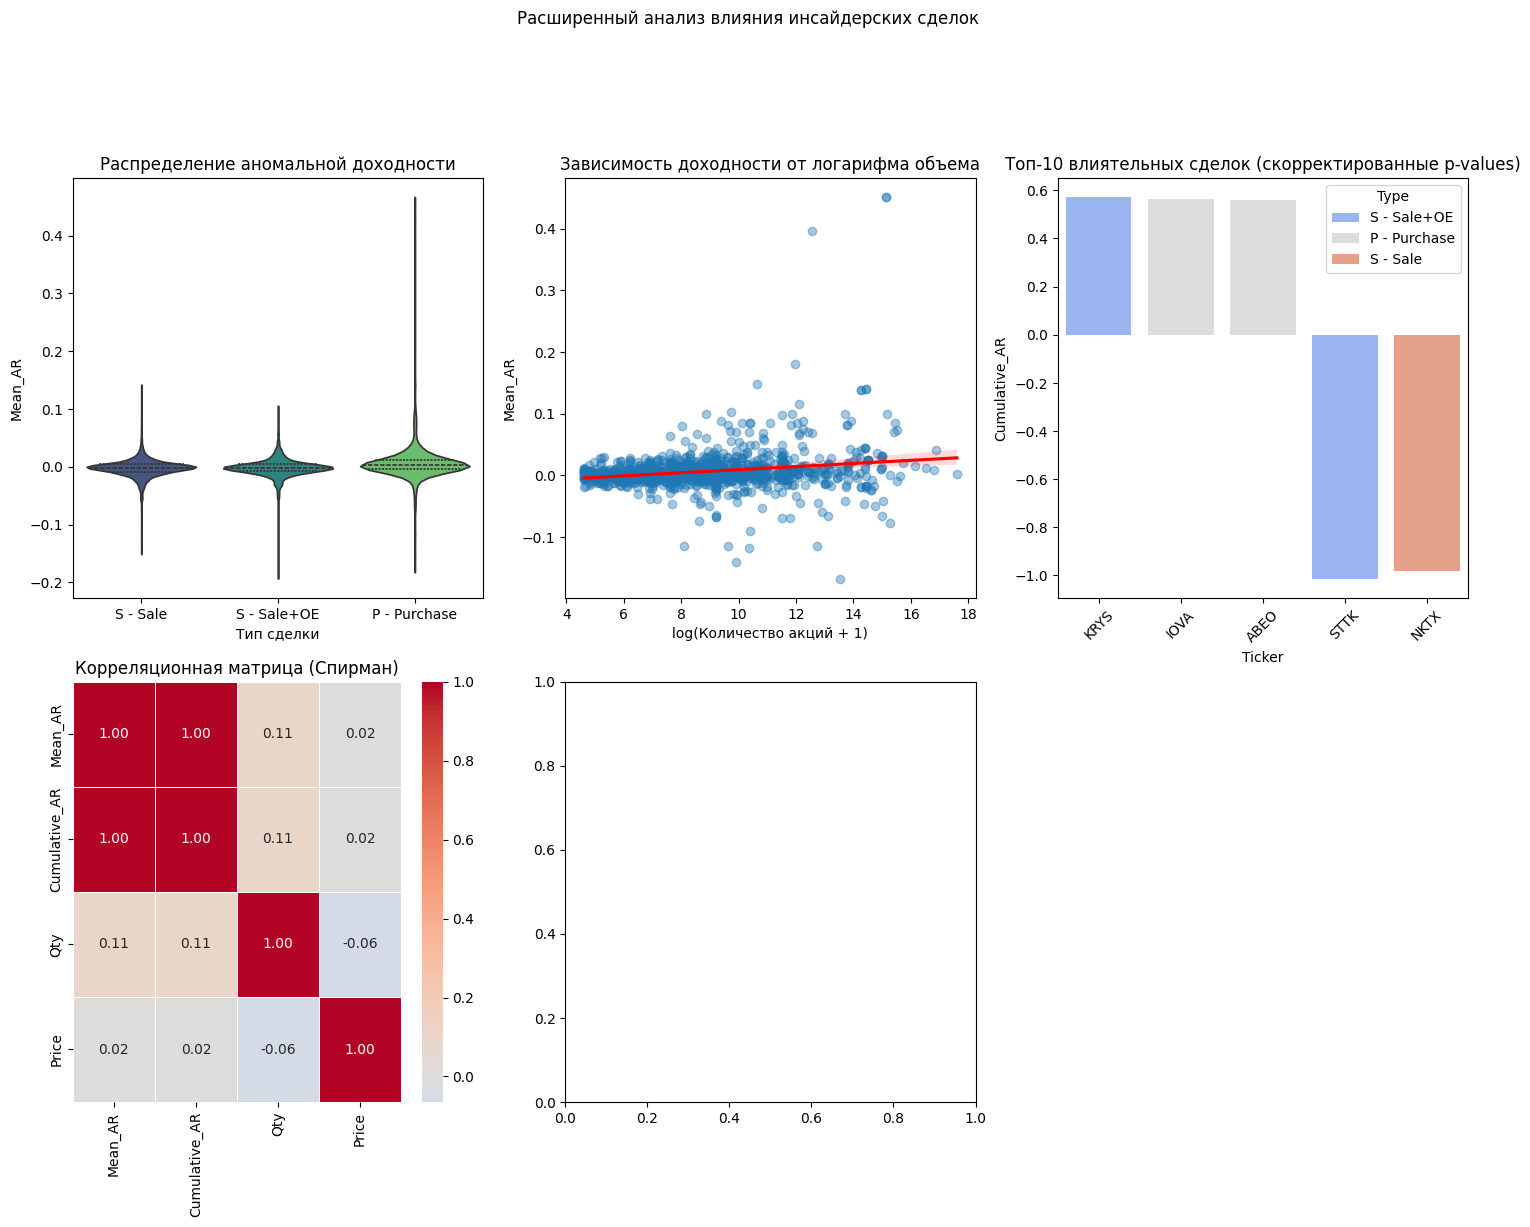

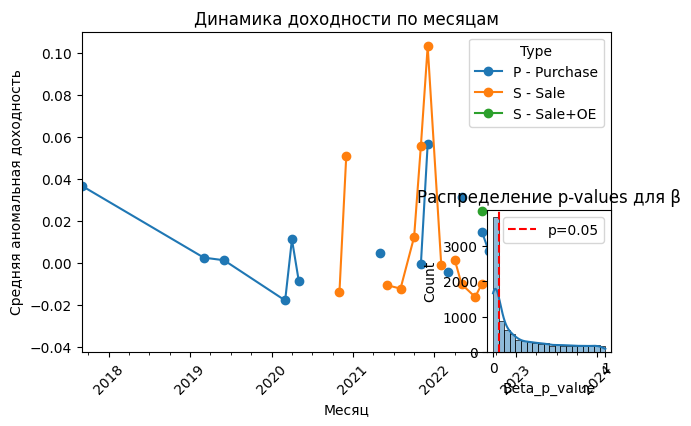

РАСШИРЕННЫЙ АНАЛИЗ ВЛИЯНИЯ ИНСАЙДЕРСКИХ СДЕЛОК

1. ОСНОВНАЯ СТАТИСТИКА:
| Type         |   Mean_AR_mean |   Mean_AR_std |   Mean_AR_median |   Mean_AR_skew |   Mean_AR_<lambda_0> |   Cumulative_AR_mean |   Cumulative_AR_sum |   Cumulative_AR_median |   Cumulative_AR_max |   Cumulative_AR_min |   Beta_p_value_<lambda_0> |   Beta_p_value_mean |     Qty_mean |   Qty_median |         Qty_sum |
|:-------------|---------------:|--------------:|-----------------:|---------------:|---------------------:|---------------------:|--------------------:|-----------------------:|--------------------:|--------------------:|--------------------------:|--------------------:|-------------:|-------------:|----------------:|
| P - Purchase |         0.0061 |        0.0319 |           0.0026 |         5.9494 |               0.5955 |               0.0423 |             54.4275 |                 0.0188 |              2.7100 |             -1.0051 |                    0.2252 |              0.3520 |  243704.6033 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

# 1. Улучшенная функция для анализа влияния сделок
def enhanced_analyze_insider_impact(df):
    # Основные статистики с дополнительными метриками
    stats_summary = df.groupby('Type').agg({
        'Mean_AR': ['mean', 'std', 'median', 'skew', lambda x: (x > 0).mean()],
        'Cumulative_AR': ['mean', 'sum', 'median', 'max', 'min'],
        'Beta_p_value': [lambda x: (x < 0.05).mean(), 'mean'],
        'Qty': ['mean', 'median', 'sum']
    })
    stats_summary.columns = ['_'.join(col).strip() for col in stats_summary.columns.values]

    # Добавляем анализ по отраслям (если есть данные)
    if 'Sector' in df.columns:
        sector_stats = df.groupby(['Transaction_Type', 'Sector'])['Mean_AR'].mean().unstack()
    else:
        sector_stats = None

    # Многомерный анализ
    purchase_ar = df[df['Type'] == 'Purchase']['Mean_AR']
    sale_ar = df[df['Type'] == 'Sale']['Mean_AR']

    # T-тест и U-тест (для непараметрических данных)
    t_stat, t_pvalue = stats.ttest_ind(purchase_ar, sale_ar, nan_policy='omit')
    u_stat, u_pvalue = stats.mannwhitneyu(purchase_ar, sale_ar, alternative='two-sided')

    # Корреляционный анализ
    corr_matrix = df[['Mean_AR', 'Cumulative_AR', 'Qty', 'Price']].corr(method='spearman')

    # Анализ влиятельных сделок с поправкой на множественное тестирование
    influential = df[(abs(df['Mean_AR']) > 0.01) & (df['Beta_p_value'] < 0.05)].copy()
    _, influential['Beta_p_value_adj'], _, _ = multipletests(
        influential['Beta_p_value'], method='fdr_bh'
    )
    influential_pct = len(influential) / len(df) * 100

    # Анализ временных трендов (если есть даты)
    if 'Trade Date' in df.columns:
        df['Trade Date'] = pd.to_datetime(df['Trade Date'])
        df['YearMonth'] = df['Trade Date'].dt.to_period('M')
        time_trend = df.groupby(['YearMonth', 'Type'])['Mean_AR'].mean().unstack()
    else:
        time_trend = None

    return {
        'stats_summary': stats_summary,
        'sector_stats': sector_stats,
        't_test': (t_stat, t_pvalue),
        'u_test': (u_stat, u_pvalue),
        'corr_matrix': corr_matrix,
        'influential_pct': influential_pct,
        'time_trend': time_trend,
        'influential_deals': influential
    }

# 2. Улучшенная функция визуализации
def enhanced_plot_analysis(df, results):
    plt.figure(figsize=(18, 12))
    plt.suptitle('Расширенный анализ влияния инсайдерских сделок', y=1.02)

    # График 1: Распределение доходности с квантилями
    plt.subplot(2, 3, 1)
    sns.violinplot(data=df, x='Type', y='Mean_AR',
                  palette='viridis', inner='quartile')
    plt.title('Распределение аномальной доходности')
    plt.xlabel('Тип сделки')
    plt.ylabel('Mean_AR')

    # График 2: Объем vs Доходность с регрессией
    plt.subplot(2, 3, 2)
    sns.regplot(data=df, x=np.log1p(df['Qty']), y='Mean_AR',
               scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    plt.title('Зависимость доходности от логарифма объема')
    plt.xlabel('log(Количество акций + 1)')
    plt.ylabel('Mean_AR')

    # График 3: Топ влиятельных сделок
    plt.subplot(2, 3, 3)
    top_deals = pd.concat([
        results['influential_deals'].nlargest(5, 'Cumulative_AR'),
        results['influential_deals'].nsmallest(5, 'Cumulative_AR')
    ])
    sns.barplot(data=top_deals, x='Ticker', y='Cumulative_AR',
               hue='Type', palette='coolwarm')
    plt.title('Топ-10 влиятельных сделок (скорректированные p-values)')
    plt.xticks(rotation=45)

    # График 4: Корреляционная матрица
    plt.subplot(2, 3, 4)
    sns.heatmap(results['corr_matrix'], annot=True, cmap='coolwarm',
               center=0, fmt=".2f", linewidths=0.5)
    plt.title('Корреляционная матрица (Спирман)')

    # График 5: Временные тренды (если есть)
    if results['time_trend'] is not None:
        plt.subplot(2, 3, 5)
        results['time_trend'].plot(marker='o')
        plt.title('Динамика доходности по месяцам')
        plt.ylabel('Средняя аномальная доходность')
        plt.xlabel('Месяц')
        plt.xticks(rotation=45)

    # График 6: Распределение p-values
    plt.subplot(2, 3, 6)
    sns.histplot(data=df, x='Beta_p_value', bins=20, kde=True)
    plt.axvline(0.05, color='red', linestyle='--', label='p=0.05')
    plt.title('Распределение p-values для β')
    plt.xlabel('Beta_p_value')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Дополнительные графики по секторам (если есть)
    if results['sector_stats'] is not None:
        plt.figure(figsize=(12, 6))
        results['sector_stats'].T.plot(kind='bar', stacked=True)
        plt.title('Средняя доходность по секторам')
        plt.ylabel('Mean_AR')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 3. Улучшенный вывод результатов
def enhanced_print_results(results):
    print("="*70)
    print("РАСШИРЕННЫЙ АНАЛИЗ ВЛИЯНИЯ ИНСАЙДЕРСКИХ СДЕЛОК")
    print("="*70)

    print("\n1. ОСНОВНАЯ СТАТИСТИКА:")
    print(results['stats_summary'].to_markdown(floatfmt=".4f"))

    print(f"\n2. СТАТИСТИЧЕСКИЕ ТЕСТЫ:")
    print(f"T-тест (покупки vs продажи): t = {results['t_test'][0]:.2f}, p = {results['t_test'][1]:.4f}")
    print(f"U-тест Манна-Уитни: U = {results['u_test'][0]:.0f}, p = {results['u_test'][1]:.4f}")

    print(f"\n3. ВЛИЯТЕЛЬНЫЕ СДЕЛКИ: {results['influential_pct']:.1f}% сделок значимы")

    print("\n4. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ:")
    print(results['corr_matrix'].to_markdown(floatfmt=".2f"))

    print("\n5. ИНТЕРПРЕТАЦИЯ:")
    if results['t_test'][1] < 0.05:
        purchase_mean = results['stats_summary'].loc['Purchase', 'Mean_AR_mean']
        sale_mean = results['stats_summary'].loc['Sale', 'Mean_AR_mean']
        if purchase_mean > sale_mean:
            print("- Инсайдерские покупки имеют значимо более положительное влияние (p < 0.05)")
            print(f"- Средний эффект: покупки {purchase_mean:.4f} vs продажи {sale_mean:.4f}")
        else:
            print("- Инсайдерские продажи имеют значимо более отрицательное влияние (p < 0.05)")
    else:
        print("- Нет значимой разницы между покупками и продажами (p > 0.05)")

    if results['influential_pct'] > 50:
        print("- Большинство сделок оказывают статистически значимое влияние")
    else:
        print("- Менее половины сделок оказывают статистически значимое влияние")

    if 'Sector' in df.columns:
        best_sector = results['sector_stats'].mean().idxmax()
        worst_sector = results['sector_stats'].mean().idxmin()
        print(f"\n6. СЕКТОРАЛЬНЫЙ АНАЛИЗ:")
        print(f"- Наиболее чувствительный сектор: {best_sector}")
        print(f"- Наименее чувствительный сектор: {worst_sector}")

# Применение улучшенных функций
analysis_results = enhanced_analyze_insider_impact(df_cleaned)
enhanced_plot_analysis(df_cleaned, analysis_results)
enhanced_print_results(analysis_results)

# Сохранение результатов
analysis_results['influential_deals'].to_csv('influential_deals_analyzed.csv', index=False)
print("\nАнализ завершен. Результаты сохранены в 'influential_deals_analyzed.csv'")